# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 2. Read Dataset

In [3]:
df = pd.read_csv('../../data/input/input_dataset.csv')

df = df.dropna(axis=0).reset_index(drop=True)
df.head()

,Referee,Day Of Week,Round,Days,Shots,ShotsOT,Corners,Fouls,YCards,RCards,GoalsScored,GoalsConceded,GoalsDiff,HTGoalsScored,HTGoalsConceded,HTGoalsDiff,Points,WinPercent,WinStreak,UnbPercent,UnbStreak,Def,Mid,Att,Ovr,LastSeasonRank,PromotedMatchup,WinnerOdd,DrawOdd,Venue,Result
0,L Probert,Sat,1.0,-4,10.4,6.6,3.8,-1.8,0.0,0.0,0.8,0.4,2.0,0.0,0.4,-2.0,0.4,20.0,0.0,0.0,1.0,7,8,8,7.67,-12,0,-9.71,5.50,Etihad Stadium,W
1,M Halsey,Sat,1.0,1,-1.0,-0.2,0.0,-1.8,0.4,0.0,0.2,0.0,1.0,0.4,0.2,1.0,-0.2,0.0,0.0,-20.0,-1.0,1,1,-2,0.00,1,0,-2.25,3.30,Bet365 Stadium,D
2,L Mason,Sat,1.0,0,6.8,5.0,1.8,-0.2,0.4,0.2,1.6,0.6,5.0,1.4,1.0,2.0,0.4,0.0,0.0,40.0,7.0,3,0,-1,0.67,-6,0,-6.56,4.20,Goodison Park,W
3,L Probert,Sun,1.0,0,3.4,2.2,2.0,0.2,-0.6,0.0,1.8,0.6,6.0,0.4,0.4,0.0,1.0,20.0,0.0,60.0,5.0,1,2,1,1.34,-4,0,-3.58,3.75,Craven Cottage,L
4,P Dowd,Sun,1.0,-1,-2.4,-1.8,-0.6,0.6,-1.0,0.0,-0.4,-1.2,4.0,0.2,0.0,1.0,1.0,20.0,0.0,60.0,6.0,-1,-3,-5,-3.00,-1,0,-1.50,3.30,Carrow Road,W


In [4]:
# label encode categorical feature- Day Of Week
dayOfWeek_le = LabelEncoder()
df['Day Of Week'] = dayOfWeek_le.fit_transform(df['Day Of Week'])

# label encode categorical feature- Referee
referee_le = LabelEncoder()
df['Referee'] = referee_le.fit_transform(df['Referee'])

# label encode categorical feature- Venue
venue_le = LabelEncoder()
df['Venue'] = venue_le.fit_transform(df['Venue'])

# 3. Feature Selection

In [5]:
selected_features = ['Referee', 'Shots', 'Corners', 'Points', 'UnbStreak', 'LastSeasonRank', 'PromotedMatchup', 'Venue']

# 4. Model Building- Data Split 4

- Target Variable: Win/Lose/Draw
- Balanced Sampling

### Random Forest Classifier

#### Hyperparameter Tuning using Fold 1

In [8]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = RandomForestClassifier(random_state = 0)
param_grid = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 3, 4, 5, 6],
    'criterion' :['entropy']    
}
# rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
rf_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
rf_classifier.fit(X_train, y_train)

# get the best parameters
print(rf_classifier.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 400}


#### Fold 1

In [57]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


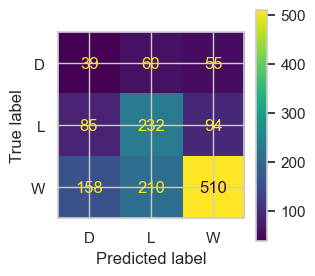

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [59]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5412335412335413
ROC score on Test Set: 0.7088145643222232

              precision    recall  f1-score   support

           0       0.14      0.25      0.18       154
           1       0.46      0.56      0.51       411
           2       0.77      0.58      0.66       878

    accuracy                           0.54      1443
   macro avg       0.46      0.47      0.45      1443
weighted avg       0.62      0.54      0.57      1443



#### Fold 2

In [60]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


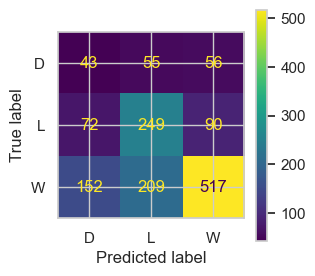

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [62]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5606375606375607
ROC score on Test Set: 0.7183652402564912

              precision    recall  f1-score   support

           0       0.16      0.28      0.20       154
           1       0.49      0.61      0.54       411
           2       0.78      0.59      0.67       878

    accuracy                           0.56      1443
   macro avg       0.48      0.49      0.47      1443
weighted avg       0.63      0.56      0.58      1443



#### Fold 3

In [63]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


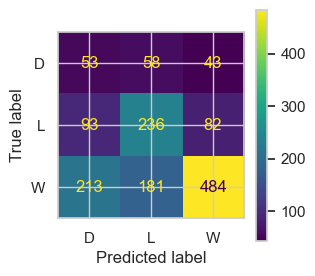

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [65]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5356895356895357
ROC score on Test Set: 0.7227415014787101

              precision    recall  f1-score   support

           0       0.15      0.34      0.21       154
           1       0.50      0.57      0.53       411
           2       0.79      0.55      0.65       878

    accuracy                           0.54      1443
   macro avg       0.48      0.49      0.46      1443
weighted avg       0.64      0.54      0.57      1443



#### Fold 4

In [66]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


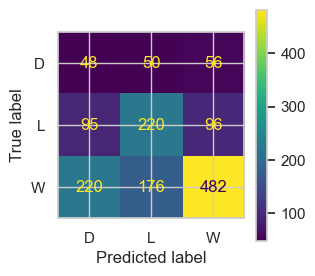

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [68]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5197505197505198
ROC score on Test Set: 0.7043158697920897

              precision    recall  f1-score   support

           0       0.13      0.31      0.19       154
           1       0.49      0.54      0.51       411
           2       0.76      0.55      0.64       878

    accuracy                           0.52      1443
   macro avg       0.46      0.47      0.45      1443
weighted avg       0.62      0.52      0.55      1443



#### Fold 5

In [69]:
# rf_classifier
rf_classifier = RandomForestClassifier(criterion='entropy', max_depth=4, max_features='sqrt', n_estimators=400, random_state=0)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
rf_classifier.fit(X_train, y_train)

# predict test set
y_pred = rf_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


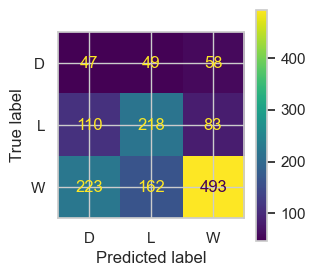

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [71]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = rf_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5252945252945252
ROC score on Test Set: 0.7098147295010913

              precision    recall  f1-score   support

           0       0.12      0.31      0.18       154
           1       0.51      0.53      0.52       411
           2       0.78      0.56      0.65       878

    accuracy                           0.53      1443
   macro avg       0.47      0.47      0.45      1443
weighted avg       0.63      0.53      0.56      1443



### Logistic Regression

#### Hyperparameter Tuning using Fold 1

In [11]:
X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = LogisticRegression(random_state = 0)
param_grid = {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
}
# lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
lr_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
lr_classifier.fit(X_train, y_train)

# get the best parameters
print(lr_classifier.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
{'C': 0.012742749857031334, 'penalty': 'l2', 'solver': 'liblinear'}


#### Fold 1

In [42]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0127, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


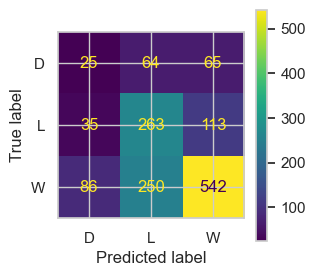

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5751905751905751
ROC score on Test Set: 0.7060221002366303

              precision    recall  f1-score   support

           0       0.17      0.16      0.17       154
           1       0.46      0.64      0.53       411
           2       0.75      0.62      0.68       878

    accuracy                           0.58      1443
   macro avg       0.46      0.47      0.46      1443
weighted avg       0.61      0.58      0.58      1443



#### Fold 2

In [45]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0127, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


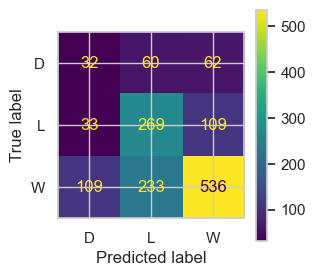

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [47]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.58004158004158
ROC score on Test Set: 0.7174960467024365

              precision    recall  f1-score   support

           0       0.18      0.21      0.20       154
           1       0.48      0.65      0.55       411
           2       0.76      0.61      0.68       878

    accuracy                           0.58      1443
   macro avg       0.47      0.49      0.47      1443
weighted avg       0.62      0.58      0.59      1443



#### Fold 3

In [48]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0127, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


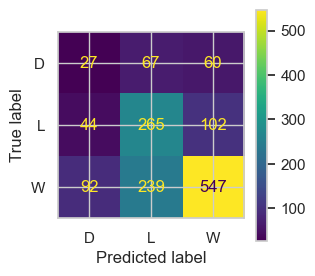

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [50]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5814275814275814
ROC score on Test Set: 0.7197830992063133

              precision    recall  f1-score   support

           0       0.17      0.18      0.17       154
           1       0.46      0.64      0.54       411
           2       0.77      0.62      0.69       878

    accuracy                           0.58      1443
   macro avg       0.47      0.48      0.47      1443
weighted avg       0.62      0.58      0.59      1443



#### Fold 4

In [51]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0127, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


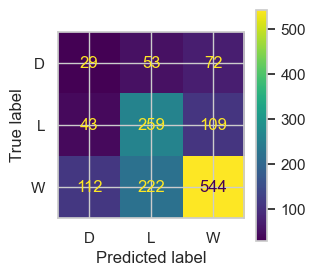

In [52]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [53]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5765765765765766
ROC score on Test Set: 0.7117153869770801

              precision    recall  f1-score   support

           0       0.16      0.19      0.17       154
           1       0.49      0.63      0.55       411
           2       0.75      0.62      0.68       878

    accuracy                           0.58      1443
   macro avg       0.46      0.48      0.47      1443
weighted avg       0.61      0.58      0.59      1443



#### Fold 5

In [54]:
# logistic regression
lr_classifier = LogisticRegression(C=0.0127, penalty='l2', solver='liblinear', random_state = 0)
            
# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
lr_classifier.fit(X_train, y_train)

# predict test set
y_pred = lr_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


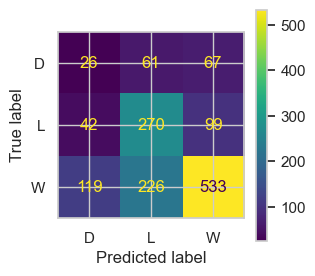

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [56]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = lr_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5744975744975745
ROC score on Test Set: 0.7105503872940625

              precision    recall  f1-score   support

           0       0.14      0.17      0.15       154
           1       0.48      0.66      0.56       411
           2       0.76      0.61      0.68       878

    accuracy                           0.57      1443
   macro avg       0.46      0.48      0.46      1443
weighted avg       0.62      0.57      0.59      1443



### SVM Classifier

#### Hyperparameter Tuning using Fold 1

In [10]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = LinearSVC(random_state = 0, dual=False)
param_grid = {
    'C': [1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1, 100, 1000], 
    'tol': [1e-300, 1e-200, 1e-100, 1e-50, 1e-30, 1e-20, 1e-10, 1e-5, 1e-1, 1],
}
# svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro') 
svc_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy') 
svc_classifier.fit(X_train, y_train)

# get the best parameters
print(svc_classifier.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'C': 0.1, 'tol': 0.1}


#### Fold 1

In [12]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


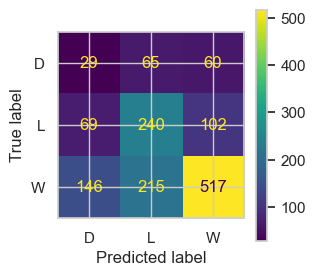

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [14]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5446985446985447
ROC score on Test Set: 0.7014876368445866

              precision    recall  f1-score   support

           0       0.12      0.19      0.15       154
           1       0.46      0.58      0.52       411
           2       0.76      0.59      0.66       878

    accuracy                           0.54      1443
   macro avg       0.45      0.45      0.44      1443
weighted avg       0.61      0.54      0.57      1443



#### Fold 2

In [15]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


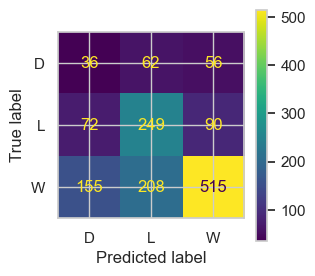

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [17]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5544005544005544
ROC score on Test Set: 0.7120325235586703

              precision    recall  f1-score   support

           0       0.14      0.23      0.17       154
           1       0.48      0.61      0.54       411
           2       0.78      0.59      0.67       878

    accuracy                           0.55      1443
   macro avg       0.47      0.48      0.46      1443
weighted avg       0.63      0.55      0.58      1443



#### Fold 3

In [18]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


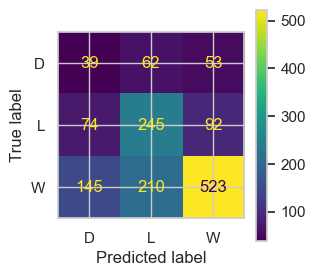

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [20]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5592515592515592
ROC score on Test Set: 0.7146253939748605

              precision    recall  f1-score   support

           0       0.15      0.25      0.19       154
           1       0.47      0.60      0.53       411
           2       0.78      0.60      0.68       878

    accuracy                           0.56      1443
   macro avg       0.47      0.48      0.46      1443
weighted avg       0.63      0.56      0.58      1443



#### Fold 4

In [21]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


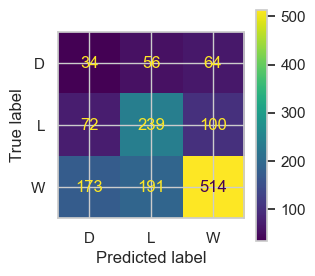

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [23]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5453915453915454
ROC score on Test Set: 0.700742487365852

              precision    recall  f1-score   support

           0       0.12      0.22      0.16       154
           1       0.49      0.58      0.53       411
           2       0.76      0.59      0.66       878

    accuracy                           0.55      1443
   macro avg       0.46      0.46      0.45      1443
weighted avg       0.61      0.55      0.57      1443



#### Fold 5

In [24]:
# linear SVC
svc_classifier = CalibratedClassifierCV(LinearSVC(C=0.1, tol=0.1, random_state=0, dual=False))

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
svc_classifier.fit(X_train, y_train)

# predict test set
y_pred = svc_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


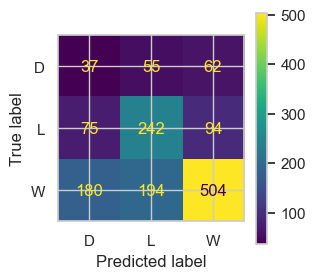

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = svc_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5426195426195426
ROC score on Test Set: 0.7030460517844425

              precision    recall  f1-score   support

           0       0.13      0.24      0.17       154
           1       0.49      0.59      0.54       411
           2       0.76      0.57      0.66       878

    accuracy                           0.54      1443
   macro avg       0.46      0.47      0.45      1443
weighted avg       0.62      0.54      0.57      1443



### XGBoost Classifier

#### Hyperparameter Tuning using Fold 1

In [9]:
# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

classifier = XGBClassifier()
param_grid = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
# xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='f1_macro')
xgb_classifier = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, verbose=1, scoring='accuracy')
xgb_classifier.fit(X_train, y_train)

# get the best parameters
print(xgb_classifier.best_params_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 60}


#### Fold 1

In [27]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=60)

# data splitting
train_set = pd.read_csv(f'./fold-1/train.csv')
test_set = pd.read_csv(f'./fold-1/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


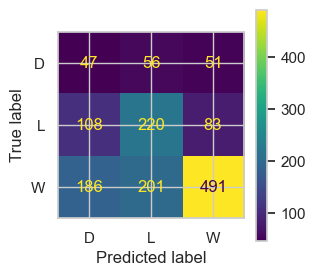

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [29]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5252945252945252
ROC score on Test Set: 0.7025738799301563

              precision    recall  f1-score   support

           0       0.14      0.31      0.19       154
           1       0.46      0.54      0.50       411
           2       0.79      0.56      0.65       878

    accuracy                           0.53      1443
   macro avg       0.46      0.47      0.45      1443
weighted avg       0.62      0.53      0.56      1443



#### Fold 2

In [30]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=60)

# data splitting
train_set = pd.read_csv(f'./fold-2/train.csv')
test_set = pd.read_csv(f'./fold-2/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


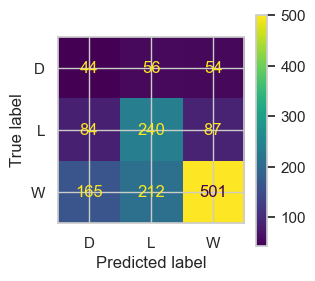

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [32]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.544005544005544
ROC score on Test Set: 0.7186918941797756

              precision    recall  f1-score   support

           0       0.15      0.29      0.20       154
           1       0.47      0.58      0.52       411
           2       0.78      0.57      0.66       878

    accuracy                           0.54      1443
   macro avg       0.47      0.48      0.46      1443
weighted avg       0.63      0.54      0.57      1443



#### Fold 3

In [33]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=60)

# data splitting
train_set = pd.read_csv(f'./fold-3/train.csv')
test_set = pd.read_csv(f'./fold-3/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


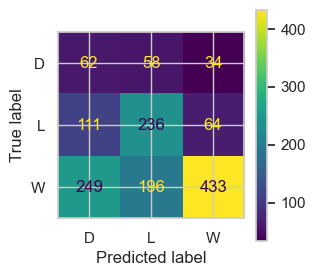

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [35]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5065835065835066
ROC score on Test Set: 0.7225444238807007

              precision    recall  f1-score   support

           0       0.15      0.40      0.22       154
           1       0.48      0.57      0.52       411
           2       0.82      0.49      0.61       878

    accuracy                           0.51      1443
   macro avg       0.48      0.49      0.45      1443
weighted avg       0.65      0.51      0.55      1443



#### Fold 4

In [36]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=60)

# data splitting
train_set = pd.read_csv(f'./fold-4/train.csv')
test_set = pd.read_csv(f'./fold-4/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


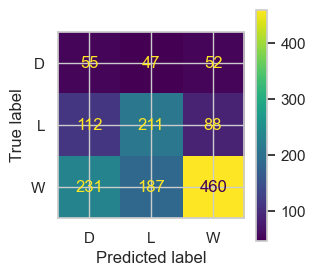

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5031185031185031
ROC score on Test Set: 0.7055696936641251

              precision    recall  f1-score   support

           0       0.14      0.36      0.20       154
           1       0.47      0.51      0.49       411
           2       0.77      0.52      0.62       878

    accuracy                           0.50      1443
   macro avg       0.46      0.46      0.44      1443
weighted avg       0.62      0.50      0.54      1443



#### Fold 5

In [39]:
# xgboost classifier
xgb_classifier = XGBClassifier(learning_rate=0.05, max_depth=2, n_estimators=60)

# data splitting
train_set = pd.read_csv(f'./fold-5/train.csv')
test_set = pd.read_csv(f'./fold-5/test.csv')

X_train = train_set.loc[:, selected_features]
y_train = train_set.iloc[:, -1]
X_test = test_set.loc[:, selected_features]
y_test = test_set.iloc[:, -1]

# label encode train_set & test_set 'Venue' & 'Result'
X_train['Referee'] = referee_le.transform(X_train['Referee'])
X_test['Referee'] = referee_le.transform(X_test['Referee'])

X_train['Venue'] = venue_le.transform(X_train['Venue'])
X_test['Venue'] = venue_le.transform(X_test['Venue'])

y_train = y_train.map({'D': 0, 'L': 1, 'W': 2})
y_test = y_test.map({'D': 0, 'L': 1, 'W': 2})

# numerical encode using the appropriate scaler
dnd_sc = StandardScaler()
X_train.iloc[:, 1:-2] = dnd_sc.fit_transform(X_train.iloc[:, 1:-2])
X_test.iloc[:, 1:-2] = dnd_sc.transform(X_test.iloc[:, 1:-2])

print(y_train.value_counts())
print(y_test.value_counts())

# train model
xgb_classifier.fit(X_train, y_train)

# predict test set
y_pred = xgb_classifier.predict(X_test)

0    618
1    618
2    618
Name: Result, dtype: int64
2    878
1    411
0    154
Name: Result, dtype: int64


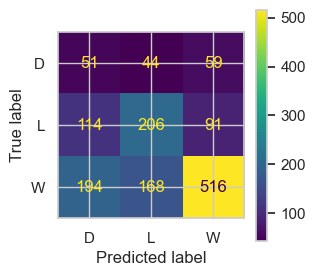

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(3, 3))

# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=['D', 'L', 'W'])
cmp.plot(ax=ax)

plt.show()

In [41]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate Accuracy
print('Accuracy on Test Set:', accuracy_score(y_test, y_pred))

# Calculate ROC_AUC
y_pred_probs = xgb_classifier.predict_proba(X_test)
print('ROC score on Test Set:', roc_auc_score(y_test, y_pred_probs, multi_class="ovr", average="weighted"))

# Get Classification Report
print()
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy on Test Set: 0.5356895356895357
ROC score on Test Set: 0.7071420563616789

              precision    recall  f1-score   support

           0       0.14      0.33      0.20       154
           1       0.49      0.50      0.50       411
           2       0.77      0.59      0.67       878

    accuracy                           0.54      1443
   macro avg       0.47      0.47      0.45      1443
weighted avg       0.63      0.54      0.57      1443

